In [1]:
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import mplhep
import matplotlib.colors as mcolors

mplhep.style.use(mplhep.style.CMS)

In [ ]:
data1 = json.load(open("report_2023-08-20T02:32:24.157176.json"))

In [ ]:
for i in range (len(data1['tests'])):
    print(data1['tests'][i]['metadata'].keys())

In [2]:
def jsonload(fname):
    with open(fname) as jsonfile:
        try:
            return json.load(jsonfile)
        except Exception:
            print(fname)
fnames = glob.glob("./data/report*.json")
fnames = np.sort(fnames)
data = [jsonload(fname) for fname in fnames]

./data/report_2023-08-19T12:38:21.931964.json


In [5]:
for i in range(len(data)):
    if data[i] == None:
        data.remove(data[i])
fnames = list(fnames) 
for i in range(len(fnames)):
    if "report_2023-08-19T12:38:21.931964.json" in fnames[i]:
        fnames.remove(fnames[i])

In [6]:
data = data[8:]
data = data[:245]
fnames = fnames[8:]
fnames = fnames[:245]

In [ ]:
## Check out fnames[250], bad ob test but the filename immediately before and after should be good 

In [7]:
goodTimes = []

for i in range(len(fnames)):
    tprim = fnames[i].split("_")[-1]
    timeb = tprim.split(".json")[0]
    times = timeb.split("T")
    timegood = times[0]+" "+times[1]
    goodTimes.append(timegood)

In [8]:
goodTimes = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in goodTimes ]
delTimes = [x - goodTimes[0] for x in goodTimes]
delTimes = np.array(delTimes)
delTimes = delTimes/timedelta(minutes=1)
rad_dose = 9.2/60
megarad_dose = rad_dose*delTimes

In [9]:
megarad_dose_plots = np.array(list(megarad_dose)+[(megarad_dose[-1]-megarad_dose[-2])+megarad_dose[-1]])

# BIST

In [10]:
voltages = []
ping_pong_bist_result = []
ob_bist_result = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "ping_pong_bist_result" in data[i]['tests'][j]['metadata']:
                ping_pong_bist_result.append(data[i]['tests'][j]['metadata']['ping_pong_bist_result'])
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                ob_bist_result.append(data[i]['tests'][j]['metadata']['ob_bist_result'])

In [11]:
ob_bist_results = dict.fromkeys(list(np.unique(np.array(voltages))))
ping_pong_bist_results = dict.fromkeys(list(np.unique(np.array(voltages))))
for key in ob_bist_results.keys():
    ob_bist_results[key] = [ob_bist_result[i] for i in range(len(voltages)) if voltages[i]==key]
for key in ping_pong_bist_results.keys():
    ping_pong_bist_results[key] = [ping_pong_bist_result[i] for i in range(len(voltages)) if voltages[i]==key]


In [12]:
pp_bist = []
for key in ping_pong_bist_results.keys():
    alexTemp1 = []
    for i in range(len(ping_pong_bist_results[1.08])):
        alexTemp = []
        for j in range(4):
            for k in range(12):
                alexTemp.append((ping_pong_bist_results[key][i][j]>> k) & 0b1)
        alexTemp1.append(alexTemp)
    pp_bist.append(alexTemp1)
pp_bist = np.array(pp_bist)
for i in range(len(pp_bist)):
    pp_bist[i] = pp_bist[i].reshape(-1,48)
    pp_bist[i] = pp_bist[i][:,[range(i,48,12) for i in range(12)]].reshape(-1,48)
ob_bist = []
for key in ob_bist_results.keys():
    alexTemp1 = []
    for i in range(len(ob_bist_results[1.08])):
        alexTemp = []
        for j in range(4):
            for k in range(12):
                alexTemp.append((ob_bist_results[key][i][j]>> k) & 0b1)
        alexTemp1.append(alexTemp)
    ob_bist.append(alexTemp1)
ob_bist = np.array(ob_bist)
for i in range(len(ob_bist)):
    ob_bist[i] = ob_bist[i].reshape(-1,48)
    ob_bist[i] = ob_bist[i][:,[range(i,48,12) for i in range(12)]].reshape(-1,48)

In [ ]:
ob_bist[0][221]

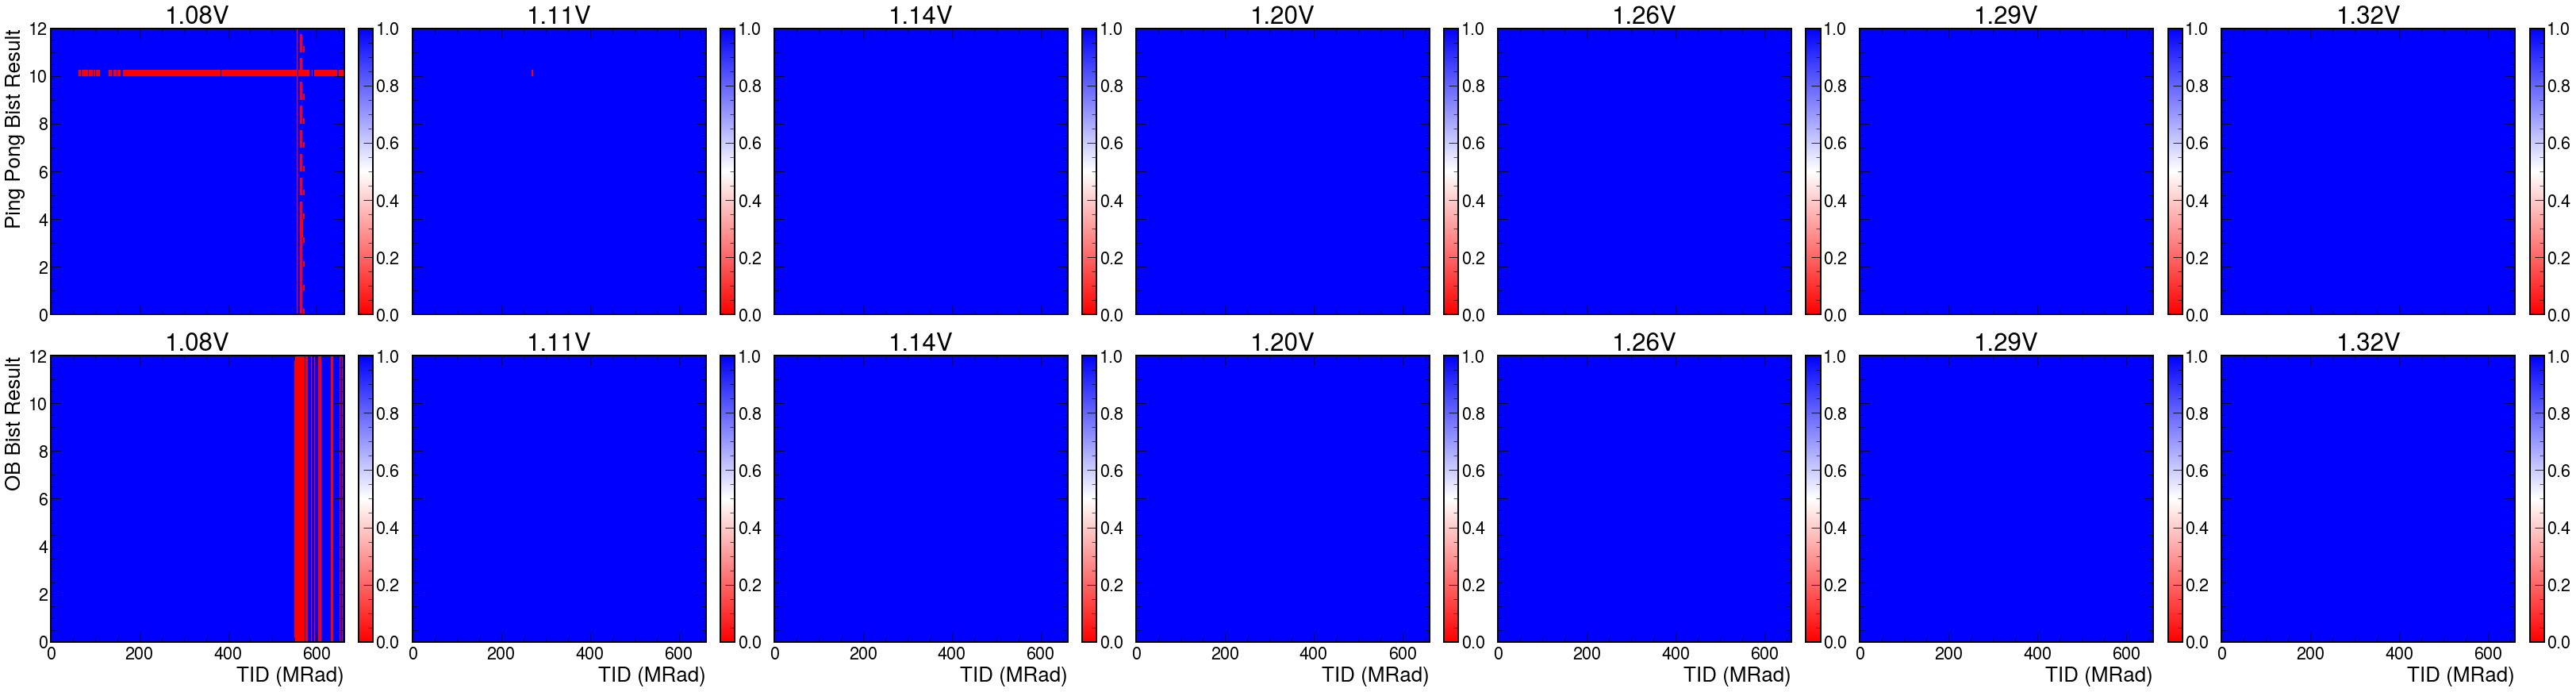

In [13]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=2, layout="constrained")

volts = [8,11,14,20,26,29,32]
for j in range(7):
    for i in range(2):
        if i == 0:
            nTrials = len(pp_bist[j])
            a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
            rand = nTrials + 1
            chData = pp_bist[j]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots ,np.arange(0,13,(12/48))),cmap='bwr_r')
            axs[i,j].set_ylim(0,12)
            if volts[j] ==8:
                axs[i,j].set_title(f"1.0{volts[j]}V")
            else:
                axs[i,j].set_title(f"1.{volts[j]}V")
            axs[i,j].set_ylabel('Ping Pong Bist Result')
            axs[i,j].set_xlabel('TID (MRad)')
            cb=fig.colorbar(h[3], ax = axs[i,j])
            
        if i == 1:
            nTrials = len(ob_bist[j])
            a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
            rand = nTrials + 1
            chData = ob_bist[j]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(0,13,(12/48))),cmap='bwr_r')
            axs[i,j].set_ylim(0,12)
            if volts[j] ==8:
                axs[i,j].set_title(f"1.0{volts[j]}V")
            else:
                axs[i,j].set_title(f"1.{volts[j]}V")
            axs[i,j].set_ylabel('OB Bist Result')
            cb=fig.colorbar(h[3], ax = axs[i,j])
            axs[i,j].set_xlabel('TID (MRad)')
for ax in axs.flat:
    ax.label_outer()
fig.savefig("./ping_pong_and_ob_bist_results.jpg")

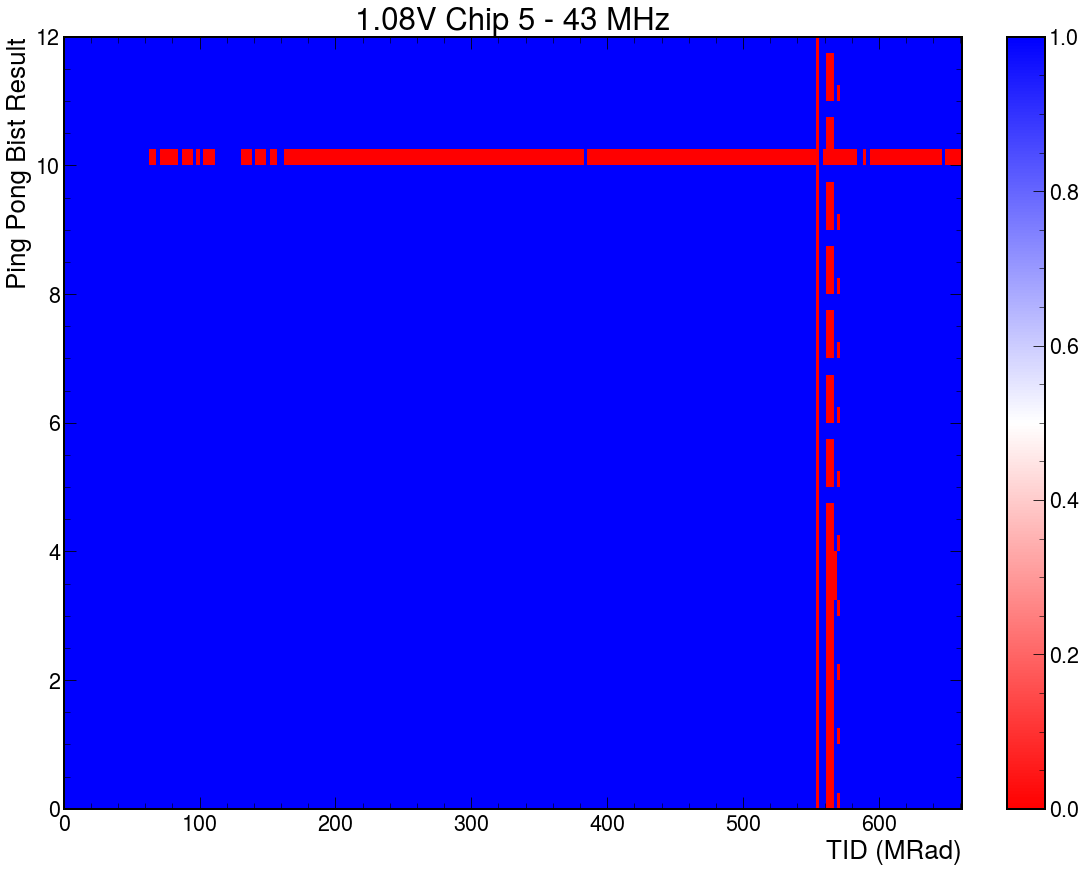

In [19]:
ncols = 2
nrows = 1
fig,axs=plt.subplots(figsize=(15,12),layout="constrained")

    

nTrials = len(pp_bist[0])
a,b=np.meshgrid(megarad_dose,np.arange(0,12,(12/48)))
rand = nTrials + 1
chData = pp_bist[0]
h = axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots ,np.arange(0,13,(12/48))),cmap='bwr_r')
axs.set_ylim(0,12)
if volts[0] ==8:
    axs.set_title(f"1.0{volts[0]}V Chip 5 - 43 MHz")
else:
    axs.set_title(f"1.0{volts[0]}V Chip 5 - 43 MHz")
axs.set_ylabel('Ping Pong Bist Result')
axs.set_xlabel('TID (MRad)')
cb=fig.colorbar(h[3], ax = axs)

fig.savefig("/Users/alexcampbell/Documents/Research/Fermilab/PLLLockingrange/plots/pp_chip5.pdf", format="pdf", bbox_inches="tight")

# Automatic Cap Bank setting vs time

In [ ]:
automatic_cap = []
voltages = []
timestamps = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                automatic_cap.append(data[i]['tests'][j]['metadata']['automatic_capbank_setting'])
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                timestamps.append(data[i]['tests'][j]['metadata']['Timestamp'][0])



In [ ]:
allowed_cap_bank_vals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                  13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                  58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                  127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506,       507,
                                  508, 509, 510, 511])
for i in range (len(automatic_cap)):
        for j in range(56):
            if automatic_cap[i] == allowed_cap_bank_vals[j]:
                automatic_cap[i] = j


In [ ]:
automatic_cap_results = dict.fromkeys(list(np.unique(np.array(voltages))))
timestamps_results = dict.fromkeys(list(np.unique(np.array(voltages))))
for key in automatic_cap_results.keys():
    automatic_cap_results[key] = [automatic_cap[i] for i in range(len(voltages)) if voltages[i]==key]
for key in timestamps_results.keys():
    timestamps_results[key] = [timestamps[i] for i in range(len(voltages)) if voltages[i]==key]
megarad_dose = dict.fromkeys(list(np.unique(np.array(voltages))))

In [ ]:
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    timestamps_results[keylist[i]] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in timestamps_results[keylist[i]] ]
    delTimes = [x - goodTimes[0] for x in timestamps_results[keylist[i]]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose[keylist[i]] = rad_dose*delTimes

In [ ]:
fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    axs[i].scatter(megarad_dose[keylist[i]],automatic_cap_results[keylist[i]])
    axs[i].set_title(f"{keylist[i]}V")
    axs[i].set_ylabel('Automatic Capbank Selection')
    axs[i].set_xlabel('TID (MRad)')
    axs[i].set_xlim(0,670)
    axs[i].set_ylim(42,50)
    axs[i].grid(which='minor', alpha=0.2, color='b', linestyle='--', linewidth=.3)
    axs[i].grid(which='major', alpha=0.2, color='b', linestyle='--', linewidth=.6)

        
for ax in axs.flat:
    ax.label_outer() 
fig.savefig("./automatic_capbank_selection_results.jpg")

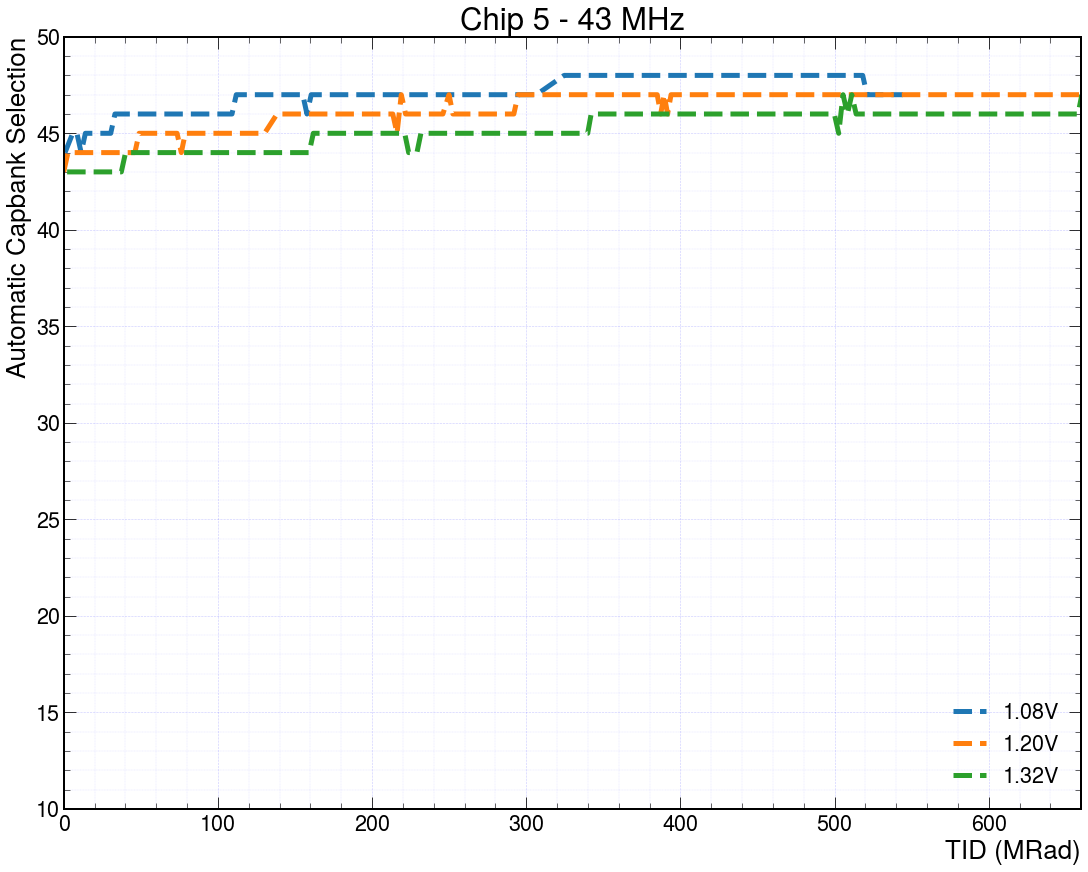

In [206]:
automatic_cap = []
frequency = 43
voltages = []
timestamps = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                automatic_cap.append(data[i]['tests'][j]['metadata']['automatic_capbank_setting'])
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                timestamps.append(data[i]['tests'][j]['metadata']['Timestamp'][0])

allowed_cap_bank_vals=np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                                13,  14,  15,  24,  25,  26,  27,  28,  29,  30,  31,  56,  57,
                                58,  59,  60,  61,  62,  63, 120, 121, 122, 123, 124, 125, 126,
                                127, 248, 249, 250, 251, 252, 253, 254, 255, 504, 505, 506,       507,
                                508, 509, 510, 511])
for i in range (len(automatic_cap)):
        for j in range(56):
            if automatic_cap[i] == allowed_cap_bank_vals[j]:
                automatic_cap[i] = j

automatic_cap_results = dict.fromkeys(list(np.unique(np.array(voltages))))
timestamps_results = dict.fromkeys(list(np.unique(np.array(voltages))))
for key in automatic_cap_results.keys():
    automatic_cap_results[key] = [automatic_cap[i] for i in range(len(voltages)) if voltages[i]==key]
for key in timestamps_results.keys():
    timestamps_results[key] = [timestamps[i] for i in range(len(voltages)) if voltages[i]==key]
megarad_dose = dict.fromkeys(list(np.unique(np.array(voltages)))) 

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    timestamps_results[keylist[i]] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in timestamps_results[keylist[i]] ]
    delTimes = [x - goodTimes[0] for x in timestamps_results[keylist[i]]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose[keylist[i]] = rad_dose*delTimes

fig,axs=plt.subplots(figsize=(15,12), layout="constrained")

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]

axs.plot(megarad_dose[1.08],automatic_cap_results[1.08], label = "1.08V" , linestyle="dashed",linewidth=5.0)
axs.plot(megarad_dose[1.20],automatic_cap_results[1.20], label = "1.20V", linestyle="dashed",linewidth=5.0)
axs.plot(megarad_dose[1.32],automatic_cap_results[1.32], label = "1.32V", linestyle="dashed",linewidth=5.0)
axs.set_title(f"Chip 5 - 43 MHz")
axs.set_ylabel('Automatic Capbank Selection')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
axs.set_ylim(10,50)
axs.grid(which='minor', alpha=0.2, color='b', linestyle='--', linewidth=.3)
axs.grid(which='major', alpha=0.2, color='b', linestyle='--', linewidth=.6)
axs.legend(loc = "lower right")


fig.savefig(f"./automatic_capbank_selection_presentation_results_{frequency}_chip5.jpg")
# return axs

In [ ]:
len(automatic_cap_results[1.08])

# Current vs Time

In [ ]:
current = []
ts = []
hasl1a = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                current.append(data[i]['tests'][j]['metadata']['Current'])
                ts.append((data[i]['tests'][j]['metadata']['Timestamp']))
                hasl1a.append((data[i]['tests'][j]['metadata']['HasL1A']))

In [ ]:
current_1_2 = []
current_1_08 = []
current_1_11 = []
current_1_14 = []
current_1_26 = []
current_1_29 = []
current_1_32 = []
ts_1_2 = []
ts_1_08 = []
ts_1_11 = []
ts_1_14 = []
ts_1_26 = []
ts_1_29 = []
ts_1_32 = []

hasl1a_1_2 = []
hasl1a_1_08 = []
hasl1a_1_11 = []
hasl1a_1_14 = []
hasl1a_1_26 = []
hasl1a_1_29 = []
hasl1a_1_32 = []

for i in range(len(voltages)):
    if voltages[i] >= 1.19 and voltages[i] <= 1.21:
        current_1_2.append(current[i])
        ts_1_2.append(ts[i])
        hasl1a_1_2.append(hasl1a[i])
    elif voltages[i] == 1.08:
        current_1_08.append(current[i])
        ts_1_08.append(ts[i])
        hasl1a_1_08.append(hasl1a[i])
    elif voltages[i] >= 1.10 and voltages[i] <= 1.12:
        current_1_11.append(current[i])
        ts_1_11.append(ts[i])
        hasl1a_1_11.append(hasl1a[i])
    elif voltages[i] >= 1.13 and voltages[i] <= 1.15:
        current_1_14.append(current[i])
        ts_1_14.append(ts[i])
        hasl1a_1_14.append(hasl1a[i])
    elif voltages[i] >= 1.25 and voltages[i] <= 1.27:
        current_1_26.append(current[i])
        ts_1_26.append(ts[i])
        hasl1a_1_26.append(hasl1a[i])
    elif voltages[i] >= 1.28 and voltages[i] <= 1.30:
        current_1_29.append(current[i])
        ts_1_29.append(ts[i])
        hasl1a_1_29.append(hasl1a[i])
    elif voltages[i] >= 1.31 and voltages[i] <= 1.32:
        current_1_32.append(current[i])
        ts_1_32.append(ts[i])
        hasl1a_1_32.append(hasl1a[i])

In [ ]:
current_1_2_tot = []
ts_1_2_tot = []
hasl1a_1_2_tot = []
for i in range (len(current_1_2)):
    for j in range(len(current_1_2[i])):
        current_1_2_tot.append(current_1_2[i][j])
        ts_1_2_tot.append(ts_1_2[i][j])
        hasl1a_1_2_tot.append(hasl1a_1_2[i][j])

current_1_08_tot = []
ts_1_08_tot = []
hasl1a_1_08_tot = []
for i in range (len(current_1_08)):
    for j in range(len(current_1_08[i])):
        current_1_08_tot.append(current_1_08[i][j])
        ts_1_08_tot.append(ts_1_08[i][j])
        hasl1a_1_08_tot.append(hasl1a_1_08[i][j])
current_1_11_tot = []
ts_1_11_tot = []
hasl1a_1_11_tot = []
for i in range (len(current_1_11)):
    for j in range(len(current_1_11[i])):
        current_1_11_tot.append(current_1_11[i][j])
        ts_1_11_tot.append(ts_1_11[i][j])
        hasl1a_1_11_tot.append(hasl1a_1_11[i][j])

current_1_14_tot = []
ts_1_14_tot = []
hasl1a_1_14_tot = []
for i in range (len(current_1_14)):
    for j in range(len(current_1_14[i])):
        current_1_14_tot.append(current_1_14[i][j])
        ts_1_14_tot.append(ts_1_14[i][j])
        hasl1a_1_14_tot.append(hasl1a_1_14[i][j])
current_1_26_tot = []
ts_1_26_tot = []
hasl1a_1_26_tot = []
for i in range (len(current_1_26)):
    for j in range(len(current_1_26[i])):
        current_1_26_tot.append(current_1_26[i][j])
        ts_1_26_tot.append(ts_1_26[i][j])
        hasl1a_1_26_tot.append(hasl1a_1_26[i][j])
current_1_29_tot = []
ts_1_29_tot = []
hasl1a_1_29_tot = []
for i in range (len(current_1_29)):
    for j in range(len(current_1_29[i])):
        current_1_29_tot.append(current_1_29[i][j])
        ts_1_29_tot.append(ts_1_29[i][j])
        hasl1a_1_29_tot.append(hasl1a_1_29[i][j])
current_1_32_tot = []
ts_1_32_tot = []
hasl1a_1_32_tot = []
for i in range (len(current_1_32)):
    for j in range(len(current_1_32[i])):
        current_1_32_tot.append(current_1_32[i][j])
        ts_1_32_tot.append(ts_1_32[i][j])
        hasl1a_1_32_tot.append(hasl1a_1_32[i][j])

In [ ]:
tot_ts_1_2 = []
tot_ts_1_08 = []
tot_ts_1_11 = []
tot_ts_1_14 = []
tot_ts_1_26 = []
tot_ts_1_29 = []
tot_ts_1_32 = []

for i in range(len(ts_1_2_tot)):
    if current_1_2_tot[i] != -1:
        tot_ts_1_2.append(ts_1_2_tot[i])
        
for i in range(len(ts_1_08_tot)):
    if current_1_08_tot[i] != -1:
        tot_ts_1_08.append(ts_1_08_tot[i])
        
for i in range(len(ts_1_11_tot)):
    if current_1_11_tot[i] != -1:
        tot_ts_1_11.append(ts_1_11_tot[i])
        
for i in range(len(ts_1_14_tot)):
    if current_1_14_tot[i] != -1:
        tot_ts_1_14.append(ts_1_14_tot[i])
        
        
for i in range(len(ts_1_26_tot)):
    if current_1_26_tot[i] != -1:
        tot_ts_1_26.append(ts_1_26_tot[i])
        
        
for i in range(len(ts_1_29_tot)):
    if current_1_29_tot[i] != -1:
        tot_ts_1_29.append(ts_1_29_tot[i])
        
for i in range(len(ts_1_32_tot)):
    if current_1_32_tot[i] != -1:
        tot_ts_1_32.append(ts_1_32_tot[i])

In [ ]:
tot_hasl1a_1_2 = []
tot_hasl1a_1_08 = []
tot_hasl1a_1_11 = []
tot_hasl1a_1_14 = []
tot_hasl1a_1_26 = []
tot_hasl1a_1_29 = []
tot_hasl1a_1_32 = []

for i in range(len(hasl1a_1_2_tot)):
    if current_1_2_tot[i] != -1:
        tot_hasl1a_1_2.append(hasl1a_1_2_tot[i])
        
for i in range(len(hasl1a_1_08_tot)):
    if current_1_08_tot[i] != -1:
        tot_hasl1a_1_08.append(hasl1a_1_08_tot[i])
        
for i in range(len(hasl1a_1_11_tot)):
    if current_1_11_tot[i] != -1:
        tot_hasl1a_1_11.append(hasl1a_1_11_tot[i])
        
for i in range(len(hasl1a_1_14_tot)):
    if current_1_14_tot[i] != -1:
        tot_hasl1a_1_14.append(hasl1a_1_14_tot[i])
        
        
for i in range(len(hasl1a_1_26_tot)):
    if current_1_26_tot[i] != -1:
        tot_hasl1a_1_26.append(hasl1a_1_26_tot[i])
        
        
for i in range(len(hasl1a_1_29_tot)):
    if current_1_29_tot[i] != -1:
        tot_hasl1a_1_29.append(hasl1a_1_29_tot[i])
        
for i in range(len(hasl1a_1_32_tot)):
    if current_1_32_tot[i] != -1:
        tot_hasl1a_1_32.append(hasl1a_1_32_tot[i])

In [ ]:
tot_hasl1a_1_2 =np.array(tot_hasl1a_1_2)
tot_hasl1a_1_08 =np.array(tot_hasl1a_1_08)
tot_hasl1a_1_11 =np.array(tot_hasl1a_1_11)
tot_hasl1a_1_14 =np.array(tot_hasl1a_1_14)
tot_hasl1a_1_26 =np.array(tot_hasl1a_1_26)
tot_hasl1a_1_29 =np.array(tot_hasl1a_1_29)
tot_hasl1a_1_32 =np.array(tot_hasl1a_1_32)

In [ ]:
tot_ts_1_2 =np.array(tot_ts_1_2)
tot_ts_1_08 =np.array(tot_ts_1_08)
tot_ts_1_11 =np.array(tot_ts_1_11)
tot_ts_1_14 =np.array(tot_ts_1_14)
tot_ts_1_26 =np.array(tot_ts_1_26)
tot_ts_1_29 =np.array(tot_ts_1_29)
tot_ts_1_32 =np.array(tot_ts_1_32)

In [ ]:
hasl1as = [tot_hasl1a_1_08, tot_hasl1a_1_11, tot_hasl1a_1_14, tot_hasl1a_1_2, tot_hasl1a_1_26, tot_hasl1a_1_29, tot_hasl1a_1_32]

In [ ]:
tss = [tot_ts_1_08, tot_ts_1_11, tot_ts_1_14, tot_ts_1_2, tot_ts_1_26, tot_ts_1_29, tot_ts_1_32]

In [ ]:
megarad_dose = []
for i in range(7):
    tss[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tss[i] ]
    delTimes = [x - goodTimes[0] for x in tss[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose.append(rad_dose*delTimes)

In [ ]:
current_1_2_tot = [x for x in current_1_2_tot if x != -1]
current_1_08_tot = [x for x in current_1_08_tot if x != -1]
current_1_11_tot = [x for x in current_1_11_tot if x != -1]
current_1_14_tot = [x for x in current_1_14_tot if x != -1]
current_1_26_tot = [x for x in current_1_26_tot if x != -1]
current_1_29_tot = [x for x in current_1_29_tot if x != -1]
current_1_32_tot = [x for x in current_1_32_tot if x != -1]

In [ ]:
current_1_2_tot = np.array(current_1_2_tot)
current_1_08_tot = np.array(current_1_08_tot)
current_1_11_tot = np.array(current_1_11_tot)
current_1_14_tot = np.array(current_1_14_tot)
current_1_26_tot = np.array(current_1_26_tot)
current_1_29_tot = np.array(current_1_29_tot)
current_1_32_tot = np.array(current_1_32_tot)

In [ ]:
currents = [current_1_08_tot,current_1_11_tot,current_1_14_tot,current_1_2_tot,current_1_26_tot,current_1_29_tot,
           current_1_32_tot]

In [ ]:
fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    axs[i].scatter(megarad_dose[i][hasl1as[i]==1], currents[i][hasl1as[i]==1], label="Has L1A")
    axs[i].scatter(megarad_dose[i][hasl1as[i]==0], currents[i][hasl1as[i]==0], label = "No L1A")
    axs[i].set_title(f"{keylist[i]}V")
    axs[i].set_ylabel('Current (A)')
    axs[i].set_xlabel('TID (MRad)')
    axs[i].set_ylim(0.15,0.31)
    axs[i].set_xlim(0,670)

        
for ax in axs.flat:
    ax.label_outer()   
fig.savefig('./current_measurement_results.jpg')

# Delay Scan Plots

In [149]:
automatic_delayscan_settings = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if 'automatic_delayscan_settings' in data[i]['tests'][j]['metadata']:
                automatic_delayscan_settings.append(data[i]['tests'][j]['metadata']['automatic_delayscan_settings'])
                

In [150]:
errcount_42 = []
bitcount_42 = []
etx_v_42 = []

errcount_43 = []
bitcount_43 = []
etx_v_43 = []

errcount_44 = []
bitcount_44 = []
etx_v_44 = []
has_var_freq = np.zeros(len(data))
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
            if "metadata" in data[i]['tests'][j]:
                if 'eTX_delays' in data[i]['tests'][j]['metadata']:
                    if "-42]" in data[i]['tests'][j]['nodeid']:
                        bitcount_42.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_42.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_42.append((data[i]['tests'][j]['metadata']['voltage']))
                        has_var_freq[i] = 1
                    elif "-43]" in data[i]['tests'][j]['nodeid']:
                        bitcount_43.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_43.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
                    elif "-44]" in data[i]['tests'][j]['nodeid']:
                        bitcount_44.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_44.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_44.append((data[i]['tests'][j]['metadata']['voltage']))
                    else:
                        bitcount_43.append(data[i]['tests'][j]['metadata']['eTX_bitcounts'])
                        errcount_43.append((data[i]['tests'][j]['metadata']['eTX_errcounts']))
                        etx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
has_var_freq1 = np.array(list(has_var_freq)+[1])

In [151]:
norm_errs_42 = (np.array(errcount_42))/(np.array(bitcount_42))
norm_errs_43 = (np.array(errcount_43))/(np.array(bitcount_43))
norm_errs_44 = (np.array(errcount_44))/(np.array(bitcount_44))

/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/3310304277.py:1: RuntimeWarning: divide by zero encountered in true_divide
  norm_errs_42 = (np.array(errcount_42))/(np.array(bitcount_42))
/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/3310304277.py:1: RuntimeWarning: invalid value encountered in true_divide
  norm_errs_42 = (np.array(errcount_42))/(np.array(bitcount_42))
/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/3310304277.py:2: RuntimeWarning: divide by zero encountered in true_divide
  norm_errs_43 = (np.array(errcount_43))/(np.array(bitcount_43))
/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/3310304277.py:2: RuntimeWarning: invalid value encountered in true_divide
  norm_errs_43 = (np.array(errcount_43))/(np.array(bitcount_43))
/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/3310304277.py:3: RuntimeWarning: invalid value encountered in true_divide
  norm_errs_44 = (np.array(errcount_44))/(np.arr

In [152]:
norm_errs_results_42 = dict.fromkeys(list(np.unique(np.array(etx_v_42))))
norm_errs_results_43 = dict.fromkeys(list(np.unique(np.array(etx_v_43))))
norm_errs_results_44 = dict.fromkeys(list(np.unique(np.array(etx_v_44))))

for key in norm_errs_results_42.keys():
    norm_errs_results_42[key] = np.array([norm_errs_42[i] for i in range(len(etx_v_42)) if etx_v_42[i]==key])
for key in norm_errs_results_43.keys():
    norm_errs_results_43[key] = np.array([norm_errs_43[i] for i in range(len(etx_v_43)) if etx_v_43[i]==key])
for key in norm_errs_results_44.keys():
    norm_errs_results_44[key] = np.array([norm_errs_44[i] for i in range(len(etx_v_44)) if etx_v_44[i]==key])


In [ ]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 1, vcenter=.1)
for j in range(len(keylist)):
    for i in range(3):
        if i == 0:
            nTrials = len(norm_errs_results_42[keylist[j]])
            a,b=np.meshgrid(megarad_dose[has_var_freq==1],np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_42[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots[has_var_freq1==1],np.arange(64)),cmap='bwr',norm=norm)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (42 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
            
      
            
        if i == 1:
            nTrials = len(norm_errs_results_43[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_43[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (43 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
        if i == 2:
            nTrials = len(norm_errs_results_44[keylist[j]])
            a,b=np.meshgrid(megarad_dose[has_var_freq==1],np.arange(63))
            rand = nTrials + 1
            chData = norm_errs_results_44[keylist[j]][:,5,:]
            h = axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots[has_var_freq1==1],np.arange(64)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Delay Scan errors for eTx 5 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Delay select setting (44 MHz)', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
for ax in axs.flat:
    ax.label_outer()
fig.savefig("./delay_scan_results.jpg")

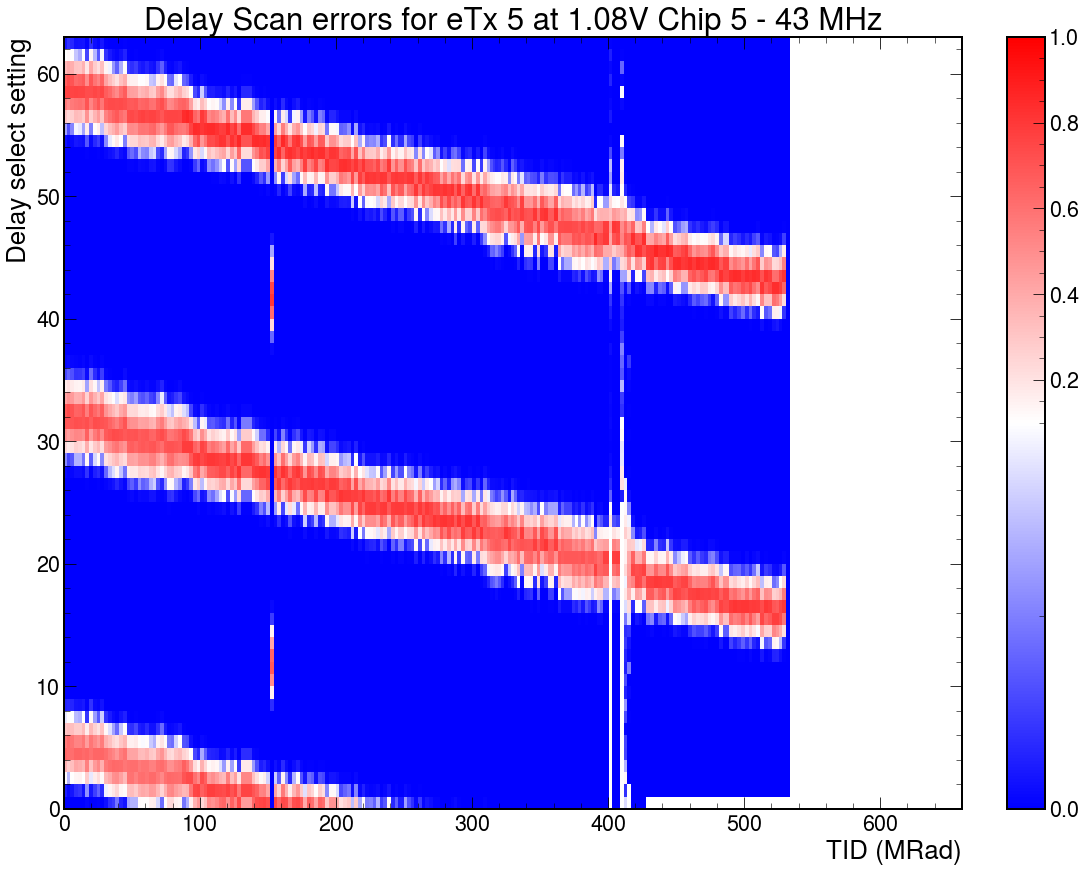

In [153]:
fig,axs=plt.subplots(figsize=(15,12), layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 1, vcenter=.1)

nTrials = len(norm_errs_results_43[1.08])
a,b=np.meshgrid(megarad_dose,np.arange(63))
rand = nTrials + 1
chData = norm_errs_results_43[1.08][:,5,:]
h = axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(64)),cmap='bwr',norm=norm)
#plt.colorbar().set_label(label='Transmission errors',size=11)
axs.set_title(f"Delay Scan errors for eTx 5 at 1.08V Chip 5 - 43 MHz")
axs.set_ylabel('Delay select setting')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
cb=fig.colorbar(h[3], ax = axs)
fig.savefig("./delay_scan_presentation_chip5.jpg")

# Phase Scan

In [224]:
automatic_phase_select_settings = []
ts = []
voltages = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if 'automatic_phase_select_settings' in data[i]['tests'][j]['metadata']:
                automatic_phase_select_settings.append(data[i]['tests'][j]['metadata']['automatic_phase_select_settings'])
                ts.append(data[i]['tests'][j]['metadata']['Timestamp'])
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])
                #print(data[i]['tests'][j]['metadata'].keys())

In [225]:

ts_1_2 = []
ts_1_08 = []
ts_1_11 = []
ts_1_14 = []
ts_1_26 = []
ts_1_29 = []
ts_1_32 = []


for i in range(len(voltages)):
    if voltages[i] >= 1.19 and voltages[i] <= 1.21:
        
        ts_1_2.append(ts[i])
        
    elif voltages[i] == 1.08:
        
        ts_1_08.append(ts[i])
        
    elif voltages[i] >= 1.10 and voltages[i] <= 1.12:
        
        ts_1_11.append(ts[i])
        
    elif voltages[i] >= 1.13 and voltages[i] <= 1.15:
        
        ts_1_14.append(ts[i])
        
    elif voltages[i] >= 1.25 and voltages[i] <= 1.27:
        
        ts_1_26.append(ts[i])
        
    elif voltages[i] >= 1.28 and voltages[i] <= 1.30:
        
        ts_1_29.append(ts[i])
        
    elif voltages[i] >= 1.31 and voltages[i] <= 1.32:
        
        ts_1_32.append(ts[i])
        

In [226]:

ts_1_2_tot = []

for i in range (len(ts_1_2)):
    for j in range(len(ts_1_2[i])):

        ts_1_2_tot.append(ts_1_2[i][j])


ts_1_08_tot = []

for i in range (len(ts_1_08)):
    for j in range(len(ts_1_08[i])):
        ts_1_08_tot.append(ts_1_08[i][j])
 


ts_1_11_tot = []

for i in range (len(ts_1_11)):
    for j in range(len(ts_1_11[i])):
        
        ts_1_11_tot.append(ts_1_11[i][j])
        

ts_1_14_tot = []

for i in range (len(ts_1_14)):
    for j in range(len(ts_1_14[i])):
        
        ts_1_14_tot.append(ts_1_14[i][j])
       
ts_1_26_tot = []

for i in range (len(ts_1_26)):
    for j in range(len(ts_1_26[i])):
       
        ts_1_26_tot.append(ts_1_26[i][j])
        

ts_1_29_tot = []

for i in range (len(ts_1_29)):
    for j in range(len(ts_1_29[i])):
        
        ts_1_29_tot.append(ts_1_29[i][j])
        

ts_1_32_tot = []

for i in range (len(ts_1_32)):
    for j in range(len(ts_1_32[i])):
        
        ts_1_32_tot.append(ts_1_32[i][j])
        

In [227]:
tss = [ts_1_08_tot, ts_1_11_tot, ts_1_14_tot, ts_1_2_tot, ts_1_26_tot, ts_1_29_tot, ts_1_32_tot]

In [228]:
megarad_dose_ps = []
for i in range(7):
    tss[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tss[i] ]
    delTimes = [x - goodTimes[0] for x in tss[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose_ps.append(rad_dose*delTimes)

In [229]:
phase_select_eRx_11 = []
for i in range(len(automatic_phase_select_settings)):
    phase_select_eRx_11.append(automatic_phase_select_settings[i][-1])
        

In [230]:
norm_errs_42 = []
norm_errs_43 = []
norm_errs_44 = []

erx_v_42 = []
erx_v_43 = []
erx_v_44 = []
has_var_freq = np.zeros(len(data))
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if 'eRX_errcounts' in data[i]['tests'][j]['metadata']:
                if "-42]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_42.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_42.append((data[i]['tests'][j]['metadata']['voltage']))
                    has_var_freq[i] = 1
                elif "-43]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_43.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
                elif "-44]" in data[i]['tests'][j]['nodeid']:
                    norm_errs_44.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_44.append((data[i]['tests'][j]['metadata']['voltage']))
                else:
                    norm_errs_43.append((data[i]['tests'][j]['metadata']['eRX_errcounts']))
                    erx_v_43.append((data[i]['tests'][j]['metadata']['voltage']))
has_var_freq1 = np.array(list(has_var_freq)+[1])

In [231]:
norm_errs_results_42 = dict.fromkeys(list(np.unique(np.array(erx_v_42))))
norm_errs_results_43 = dict.fromkeys(list(np.unique(np.array(erx_v_43))))
norm_errs_results_44 = dict.fromkeys(list(np.unique(np.array(erx_v_44))))
phase_select_11 = dict.fromkeys(list(np.unique(np.array(erx_v_43))))
ts_ps_11 = dict.fromkeys(list(np.unique(np.array(erx_v_43))))
for key in norm_errs_results_42.keys():
    norm_errs_results_42[key] = np.array([norm_errs_42[i] for i in range(len(erx_v_42)) if erx_v_42[i]==key])
for key in norm_errs_results_43.keys():
    norm_errs_results_43[key] = np.array([norm_errs_43[i] for i in range(len(erx_v_43)) if erx_v_43[i]==key])
for key in norm_errs_results_44.keys():
    norm_errs_results_44[key] = np.array([norm_errs_44[i] for i in range(len(erx_v_44)) if erx_v_44[i]==key])

TypeError: unhashable type: 'numpy.ndarray'

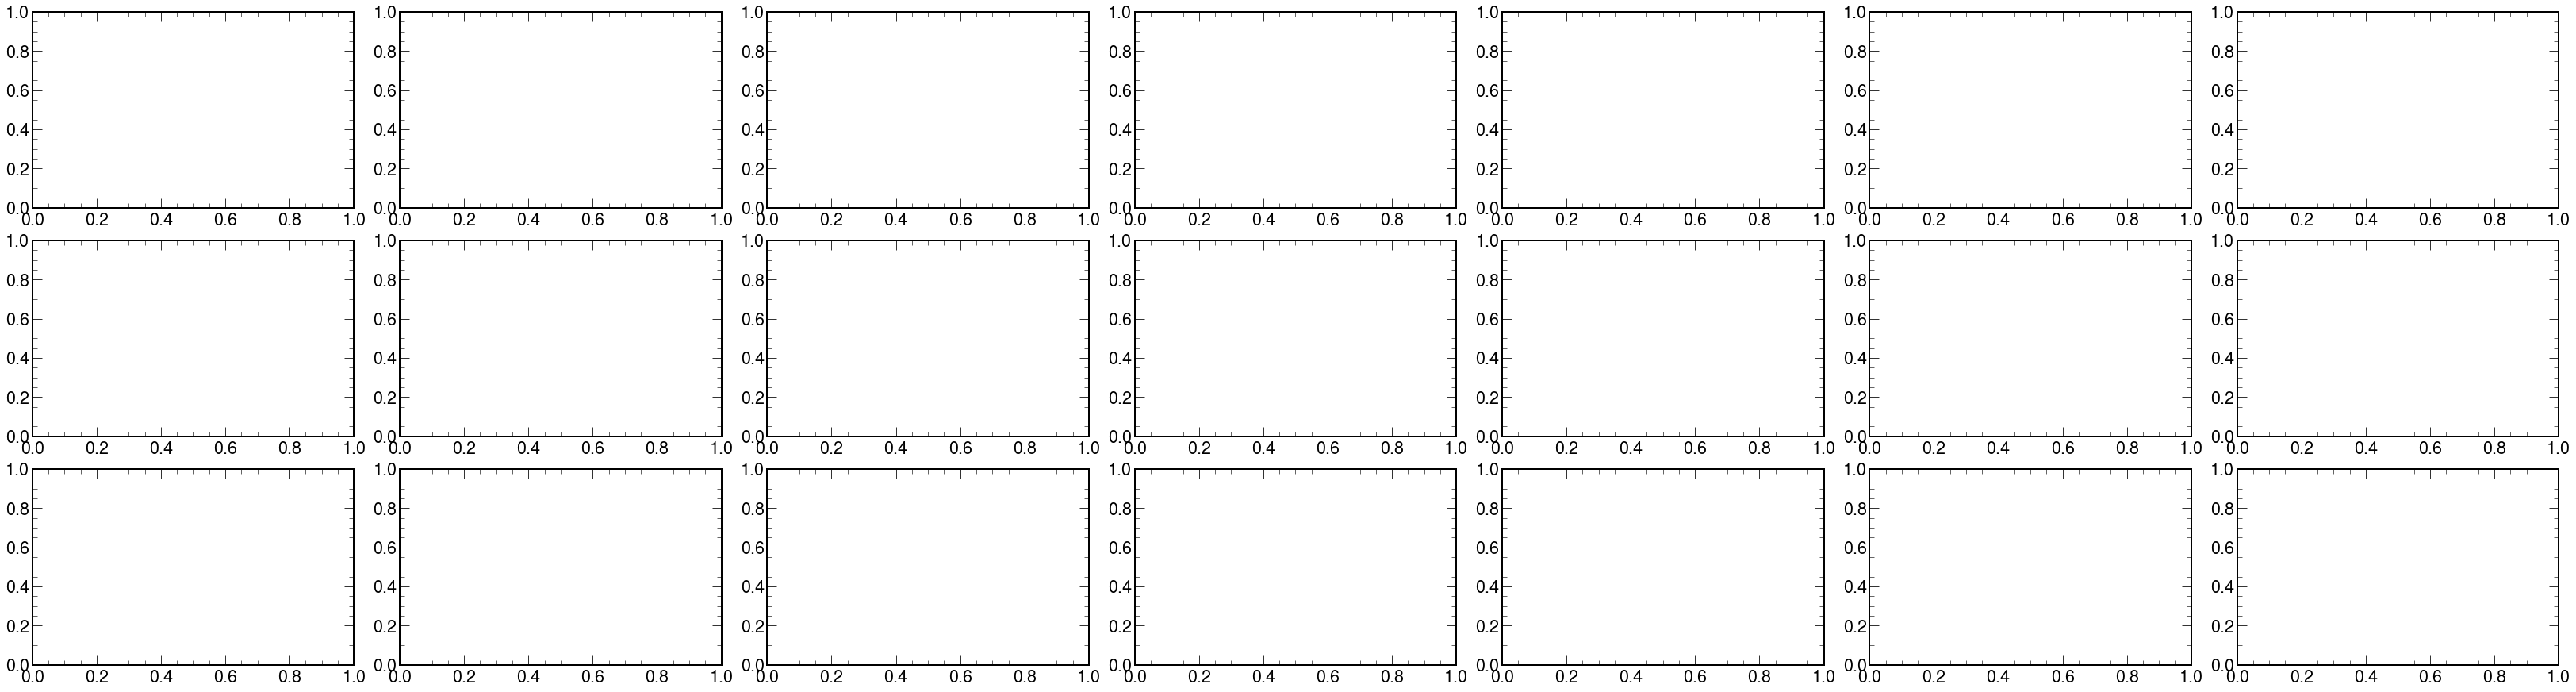

In [215]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter=.9)

for j in range(len(keylist)):
    for i in range(3):
        if i == 0:
            nTrials = len(norm_errs_results_42[keylist[j]])
            a,b=np.meshgrid(megarad_dose[has_var_freq==1],np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_42[keylist[j]][:,:,11]
            h =axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots[has_var_freq1==1],np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)

            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (42 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
            
        if i == 1:
            nTrials = len(norm_errs_results_43[keylist[j]])
            a,b=np.meshgrid(megarad_dose,np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_43[keylist[j]][:,:,11]
            h =axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (43 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
        if i == 2:
            nTrials = len(norm_errs_results_44[keylist[j]])
            a,b=np.meshgrid(megarad_dose[has_var_freq==1],np.arange(15))
            rand = nTrials + 1
            chData = norm_errs_results_44[keylist[j]][:,:,11]
            h=axs[i,j].hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots[has_var_freq1==1],np.arange(16)),cmap='bwr',norm=norm)
            #plt.colorbar().set_label(label='Transmission errors',size=11)
            axs[i,j].set_title(f"Phase Scan errors for eRx 11 at {keylist[j]}V", size=12)
            axs[i,j].set_ylabel('Phase select setting (44 MHz)', size=13)
            axs[i,j].set_xlabel('Run number', size=13)
            axs[i,j].set_xlabel('TID (MRad)', size=13)
            axs[i,j].set_xlim(0,660)
            cb=fig.colorbar(h[3], ax = axs[i,j])
for ax in axs.flat:
    ax.label_outer()
fig.savefig("./phase_scan_results.jpg")

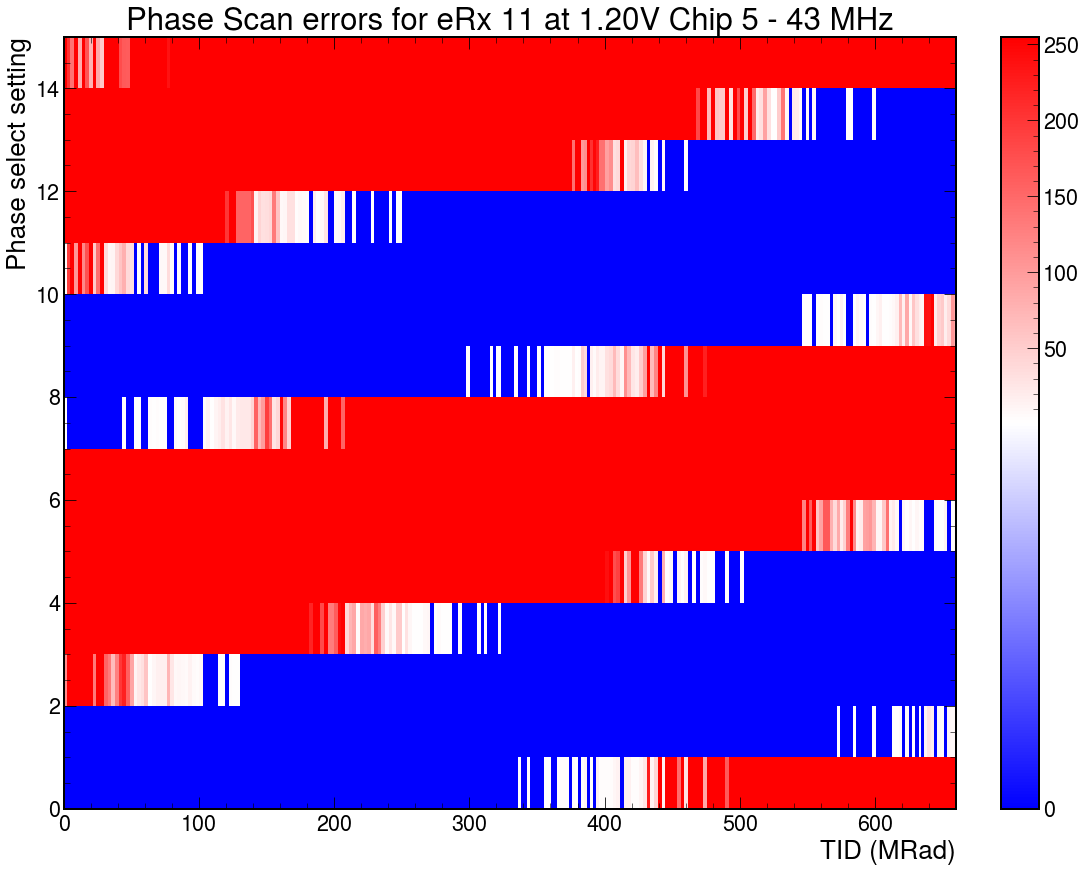

In [234]:
fig,axs=plt.subplots(figsize=(15,12), layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter=.9)
nTrials = len(norm_errs_results_43[1.20])
a,b=np.meshgrid(megarad_dose,np.arange(15))
rand = nTrials + 1
chData = norm_errs_results_43[1.20][:,:,11]
h =axs.hist2d(a.flatten(),b.flatten(),weights=chData.T.flatten(),bins=(megarad_dose_plots,np.arange(16)),cmap='bwr',norm=norm)
#plt.colorbar().set_label(label='Transmission errors',size=11)
axs.set_title(f"Phase Scan errors for eRx 11 at 1.20V Chip 5 - 43 MHz")
axs.set_ylabel('Phase select setting')
axs.set_xlabel('TID (MRad)')
axs.set_xlim(0,660)
cb=fig.colorbar(h[3], ax = axs)
fig.savefig("./phase_scan_presentation_chip5_120.jpg")

In [ ]:
len(megarad_dose_ps[0])

# Temperature vs Time

In [ ]:
temperature = []
ts = []
voltages = []
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                temperature.append(data[i]['tests'][j]['metadata']['Temperature'])
                ts.append((data[i]['tests'][j]['metadata']['Timestamp']))
                voltages.append(data[i]['tests'][j]['metadata']['voltage'])

In [ ]:
temperature_1_2 = []
temperature_1_08 = []
temperature_1_11 = []
temperature_1_14 = []
temperature_1_26 = []
temperature_1_29 = []
temperature_1_32 = []
ts_1_2 = []
ts_1_08 = []
ts_1_11 = []
ts_1_14 = []
ts_1_26 = []
ts_1_29 = []
ts_1_32 = []


for i in range(len(voltages)):
    if voltages[i] == 1.2:
        temperature_1_2.append(temperature[i])
        ts_1_2.append(ts[i])
    elif voltages[i] == 1.08:
        temperature_1_08.append(temperature[i])
        ts_1_08.append(ts[i])
    elif voltages[i] == 1.11:
        temperature_1_11.append(temperature[i])
        ts_1_11.append(ts[i])
    elif voltages[i] == 1.14:
        temperature_1_14.append(temperature[i])
        ts_1_14.append(ts[i])
    elif voltages[i] == 1.26:
        temperature_1_26.append(temperature[i])
        ts_1_26.append(ts[i])
    elif voltages[i] == 1.29:
        temperature_1_29.append(temperature[i])
        ts_1_29.append(ts[i])
    elif voltages[i] == 1.32:
        temperature_1_32.append(temperature[i])
        ts_1_32.append(ts[i])

In [ ]:
temperature_1_2_tot = []
ts_1_2_tot = []
for i in range (len(temperature_1_2)):
    for j in range(len(temperature_1_2[i])):
        temperature_1_2_tot.append(temperature_1_2[i][j])
        ts_1_2_tot.append(ts_1_2[i][j])

temperature_1_08_tot = []
ts_1_08_tot = []
for i in range (len(temperature_1_08)):
    for j in range(len(temperature_1_08[i])):
        temperature_1_08_tot.append(temperature_1_08[i][j])
        ts_1_08_tot.append(ts_1_08[i][j])
temperature_1_11_tot = []
ts_1_11_tot = []
for i in range (len(temperature_1_11)):
    for j in range(len(temperature_1_11[i])):
        temperature_1_11_tot.append(temperature_1_11[i][j])
        ts_1_11_tot.append(ts_1_11[i][j])
temperature_1_14_tot = []
ts_1_14_tot = []
for i in range (len(temperature_1_14)):
    for j in range(len(temperature_1_14[i])):
        temperature_1_14_tot.append(temperature_1_14[i][j])
        ts_1_14_tot.append(ts_1_14[i][j])
temperature_1_26_tot = []
ts_1_26_tot = []
for i in range (len(temperature_1_26)):
    for j in range(len(temperature_1_26[i])):
        temperature_1_26_tot.append(temperature_1_26[i][j])
        ts_1_26_tot.append(ts_1_26[i][j])
temperature_1_29_tot = []
ts_1_29_tot = []
for i in range (len(temperature_1_29)):
    for j in range(len(temperature_1_29[i])):
        temperature_1_29_tot.append(temperature_1_29[i][j])
        ts_1_29_tot.append(ts_1_29[i][j])
temperature_1_32_tot = []
ts_1_32_tot = []
for i in range (len(temperature_1_32)):
    for j in range(len(temperature_1_32[i])):
        temperature_1_32_tot.append(temperature_1_32[i][j])
        ts_1_32_tot.append(ts_1_32[i][j])

In [ ]:
temperatures = [temperature_1_08_tot, temperature_1_11_tot, temperature_1_14_tot, temperature_1_2_tot, temperature_1_26_tot,
               temperature_1_29_tot, temperature_1_32_tot]

In [ ]:
tss = [ts_1_08_tot, ts_1_11_tot, ts_1_14_tot, ts_1_2_tot, ts_1_26_tot, ts_1_29_tot, ts_1_32_tot]

In [ ]:
megarad_dose = []
for i in range(7):
    tss[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tss[i] ]
    delTimes = [x - goodTimes[0] for x in tss[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose.append(rad_dose*delTimes)

In [ ]:
fig,axs=plt.subplots(figsize=(70,12),ncols=7,nrows=1, layout="constrained")

keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for i in range(len(keylist)):
    axs[i].scatter(megarad_dose[i],temperatures[i])
    axs[i].set_title(f"{keylist[i]}V")
    axs[i].set_ylabel('Temperature (C)')
    axs[i].set_xlabel('TID (MRad)')
    axs[i].set_ylim(-13,5)
    axs[i].set_xlim(0,670)
    

        
for ax in axs.flat:
    ax.label_outer()
fig.savefig('./temperature_measurements.jpg')

# Error Count and Power Consumption

In [182]:
worderrcnt = []
hasl1a = []
voltages = []
wordCounts = []
errorCounts = []
timestamps=[]
for i in range(len(data)):
    for j in range(len(data[i]['tests'])):
        if "metadata" in data[i]['tests'][j]:
            if "automatic_capbank_setting" in data[i]['tests'][j]['metadata']:
                if "HasL1A" in data[i]['tests'][j]['metadata']:
                    x = (data[i]['tests'][j]['metadata']['word_err_count'])
                    voltages.append(data[i]['tests'][j]['metadata']['Voltage'])
                    hasl1a.append(data[i]['tests'][j]['metadata']['HasL1A'])
                    worderrcnt.append(data[i]['tests'][j]['metadata']['word_err_count'])
                    y=np.array(x)
                    timestamps += list(y[:,0])
                    z=y[:,1].astype(int)
                    wordCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))

                    z=y[:,2].astype(int)
                    errorCounts += list(z + np.array([0] + list(np.cumsum(((z[1:]<z[:-1]))*1)*2**32)))


In [183]:
timestamps=np.array(timestamps)
newwordCounts = np.zeros(len(wordCounts))
newerrorCounts = np.zeros(len(errorCounts))
for i in range(len(wordCounts)-1):
    newwordCounts[i] = wordCounts[i+1] - wordCounts[i]
    newerrorCounts[i] = errorCounts[i+1] - errorCounts[i]

In [184]:
timestamps

array(['2023-08-19 13:16:39.646048', '2023-08-19 13:16:45.169990',
       '2023-08-19 13:16:50.555410', ..., '2023-08-22 13:06:38.822255',
       '2023-08-22 13:06:44.206367', '2023-08-22 13:06:49.583400'],
      dtype='<U26')

In [185]:

voltages_used = []
hasl1a_tot = []

for i in range(len(worderrcnt)):
    for j in range(len(worderrcnt[i][:])):
        voltages_used.append(voltages[i][j])
        hasl1a_tot.append(hasl1a[i][j])

In [186]:
errs_1_2_l1a = []
errs_1_08_l1a = []
errs_1_11_l1a = []
errs_1_14_l1a = []
errs_1_26_l1a = []
errs_1_29_l1a = []
errs_1_32_l1a = []

errs_1_2_nol1a = []
errs_1_08_nol1a = []
errs_1_11_nol1a = []
errs_1_14_nol1a = []
errs_1_26_nol1a = []
errs_1_29_nol1a = []
errs_1_32_nol1a = []

wordcnt_1_2_l1a = []
wordcnt_1_08_l1a = []
wordcnt_1_11_l1a = []
wordcnt_1_14_l1a = []
wordcnt_1_26_l1a = []
wordcnt_1_29_l1a = []
wordcnt_1_32_l1a = []

wordcnt_1_2_nol1a = []
wordcnt_1_08_nol1a = []
wordcnt_1_11_nol1a = []
wordcnt_1_14_nol1a = []
wordcnt_1_26_nol1a = []
wordcnt_1_29_nol1a = []
wordcnt_1_32_nol1a = []

timestamps_1_2_l1a = []
timestamps_1_08_l1a = []
timestamps_1_11_l1a = []
timestamps_1_14_l1a = []
timestamps_1_26_l1a = []
timestamps_1_29_l1a = []
timestamps_1_32_l1a = []

timestamps_1_2_nol1a = []
timestamps_1_08_nol1a = []
timestamps_1_11_nol1a = []
timestamps_1_14_nol1a = []
timestamps_1_26_nol1a = []
timestamps_1_29_nol1a = []
timestamps_1_32_nol1a = []

for i in range(len(voltages_used)):
    if voltages_used[i] >= 1.19 and voltages_used[i] <= 1.21:
        if hasl1a_tot[i] == 1:
            errs_1_2_l1a.append(newerrorCounts[i])
            timestamps_1_2_l1a.append(timestamps[i])
            wordcnt_1_2_l1a.append(newwordCounts[i])
        else:
            errs_1_2_nol1a.append(newerrorCounts[i])
            wordcnt_1_2_nol1a.append(newwordCounts[i])
            timestamps_1_2_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.07 and voltages_used[i] <= 1.09:
        if hasl1a_tot[i] == 1:
            errs_1_08_l1a.append(newerrorCounts[i])
            timestamps_1_08_l1a.append(timestamps[i])
            wordcnt_1_08_l1a.append(newwordCounts[i])
        else:
            errs_1_08_nol1a.append(newerrorCounts[i])
            wordcnt_1_08_nol1a.append(newwordCounts[i])
            timestamps_1_08_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.10 and voltages_used[i] <= 1.12:
        if hasl1a_tot[i] == 1:
            errs_1_11_l1a.append(newerrorCounts[i])
            timestamps_1_11_l1a.append(timestamps[i])
            wordcnt_1_11_l1a.append(newwordCounts[i])
        else:
            errs_1_11_nol1a.append(newerrorCounts[i])
            wordcnt_1_11_nol1a.append(newwordCounts[i])
            timestamps_1_11_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.13 and voltages_used[i] <= 1.15:
        if hasl1a_tot[i] == 1:
            errs_1_14_l1a.append(newerrorCounts[i])
            timestamps_1_14_l1a.append(timestamps[i])
            wordcnt_1_14_l1a.append(newwordCounts[i])
        else:
            errs_1_14_nol1a.append(newerrorCounts[i])
            timestamps_1_14_nol1a.append(timestamps[i])
            wordcnt_1_14_nol1a.append(newwordCounts[i])
    elif voltages_used[i] >= 1.25 and voltages_used[i] <= 1.27:
        if hasl1a_tot[i] == 1:
            errs_1_26_l1a.append(newerrorCounts[i])
            timestamps_1_26_l1a.append(timestamps[i])
            wordcnt_1_26_l1a.append(newwordCounts[i])
        else:
            errs_1_26_nol1a.append(newerrorCounts[i])
            wordcnt_1_26_nol1a.append(newwordCounts[i])
            timestamps_1_26_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.28 and voltages_used[i] <= 1.30:
        if hasl1a_tot[i] == 1:
            errs_1_29_l1a.append(newerrorCounts[i])
            timestamps_1_29_l1a.append(timestamps[i])
            wordcnt_1_29_l1a.append(newwordCounts[i])
        else:
            errs_1_29_nol1a.append(newerrorCounts[i])
            wordcnt_1_29_nol1a.append(newwordCounts[i])
            timestamps_1_29_nol1a.append(timestamps[i])
    elif voltages_used[i] >= 1.31 and voltages_used[i] <= 1.32:
        if hasl1a_tot[i] == 1:
            errs_1_32_l1a.append(newerrorCounts[i])
            timestamps_1_32_l1a.append(timestamps[i])
            wordcnt_1_32_l1a.append(newwordCounts[i])
        else:
            errs_1_32_nol1a.append(newerrorCounts[i])
            wordcnt_1_32_nol1a.append(newwordCounts[i])
            timestamps_1_32_nol1a.append(timestamps[i])

In [187]:
errs_1_2_l1a = np.array(errs_1_2_l1a)
errs_1_08_l1a = np.array(errs_1_08_l1a)
errs_1_11_l1a = np.array(errs_1_11_l1a)
errs_1_14_l1a = np.array(errs_1_14_l1a)
errs_1_26_l1a = np.array(errs_1_26_l1a)
errs_1_29_l1a = np.array(errs_1_29_l1a)
errs_1_32_l1a = np.array(errs_1_32_l1a)

errs_1_2_nol1a = np.array(errs_1_2_nol1a)
errs_1_08_nol1a = np.array(errs_1_08_nol1a)
errs_1_11_nol1a = np.array(errs_1_11_nol1a)
errs_1_14_nol1a = np.array(errs_1_14_nol1a)
errs_1_26_nol1a = np.array(errs_1_26_nol1a)
errs_1_29_nol1a = np.array(errs_1_29_nol1a)
errs_1_32_nol1a = np.array(errs_1_32_nol1a)

wordcnt_1_2_l1a = np.array(wordcnt_1_2_l1a)
wordcnt_1_08_l1a = np.array(wordcnt_1_08_l1a)
wordcnt_1_11_l1a = np.array(wordcnt_1_11_l1a)
wordcnt_1_14_l1a = np.array(wordcnt_1_14_l1a)
wordcnt_1_26_l1a = np.array(wordcnt_1_26_l1a)
wordcnt_1_29_l1a = np.array(wordcnt_1_29_l1a)
wordcnt_1_32_l1a = np.array(wordcnt_1_32_l1a)

wordcnt_1_2_nol1a = np.array(wordcnt_1_2_nol1a)
wordcnt_1_08_nol1a = np.array(wordcnt_1_08_nol1a)
wordcnt_1_11_nol1a = np.array(wordcnt_1_11_nol1a)
wordcnt_1_14_nol1a = np.array(wordcnt_1_14_nol1a)
wordcnt_1_26_nol1a = np.array(wordcnt_1_26_nol1a)
wordcnt_1_29_nol1a = np.array(wordcnt_1_29_nol1a)
wordcnt_1_32_nol1a = np.array(wordcnt_1_32_nol1a)

In [188]:
errs_rate_1_2_l1a = errs_1_2_l1a/wordcnt_1_2_l1a
errs_rate_1_08_l1a = errs_1_08_l1a/wordcnt_1_08_l1a
errs_rate_1_11_l1a = errs_1_11_l1a/wordcnt_1_11_l1a
errs_rate_1_14_l1a = errs_1_14_l1a/wordcnt_1_14_l1a
errs_rate_1_26_l1a = errs_1_26_l1a/wordcnt_1_26_l1a
errs_rate_1_29_l1a = errs_1_29_l1a/wordcnt_1_29_l1a
errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a

errs_rate_1_2_nol1a = errs_1_2_nol1a/wordcnt_1_2_nol1a
errs_rate_1_08_nol1a = errs_1_08_nol1a/wordcnt_1_08_nol1a
errs_rate_1_11_nol1a = errs_1_11_nol1a/wordcnt_1_11_nol1a
errs_rate_1_14_nol1a = errs_1_14_nol1a/wordcnt_1_14_nol1a
errs_rate_1_26_nol1a = errs_1_26_nol1a/wordcnt_1_26_nol1a
errs_rate_1_29_nol1a = errs_1_29_nol1a/wordcnt_1_29_nol1a
errs_rate_1_32_nol1a = errs_1_32_nol1a/wordcnt_1_32_nol1a

/var/folders/pj/jdsydbt93y3fty8bxll08bd00000gn/T/ipykernel_1781/2078153264.py:7: RuntimeWarning: invalid value encountered in true_divide
  errs_rate_1_32_l1a = errs_1_32_l1a/wordcnt_1_32_l1a


In [189]:
errs_l1a = [errs_1_08_l1a, errs_1_11_l1a, errs_1_14_l1a, errs_1_2_l1a, errs_1_26_l1a, errs_1_29_l1a, errs_1_32_l1a]

In [190]:
errs_nol1a = [errs_1_08_nol1a, errs_1_11_nol1a, errs_1_14_nol1a, errs_1_2_nol1a, errs_1_26_nol1a, errs_1_29_nol1a, errs_1_32_nol1a]

In [191]:
wordcnt_l1a = [wordcnt_1_08_l1a, wordcnt_1_11_l1a, wordcnt_1_14_l1a, wordcnt_1_2_l1a, wordcnt_1_26_l1a, wordcnt_1_29_l1a, wordcnt_1_32_l1a]

In [192]:
wordcnt_nol1a = [wordcnt_1_08_nol1a, wordcnt_1_11_nol1a, wordcnt_1_14_nol1a, wordcnt_1_2_nol1a, wordcnt_1_26_nol1a, wordcnt_1_29_nol1a, wordcnt_1_32_nol1a]           

In [193]:
errs_rate_nol1a = [errs_rate_1_08_nol1a, errs_rate_1_11_nol1a, errs_rate_1_14_nol1a, errs_rate_1_2_nol1a, errs_rate_1_26_nol1a, errs_rate_1_29_nol1a, errs_rate_1_32_nol1a]

In [194]:
errs_rate_l1a = [errs_rate_1_08_l1a, errs_rate_1_11_l1a, errs_rate_1_14_l1a, errs_rate_1_2_l1a, errs_rate_1_26_l1a, errs_rate_1_29_l1a, errs_rate_1_32_l1a]

In [195]:
tssl1a = [timestamps_1_08_l1a, timestamps_1_11_l1a, timestamps_1_14_l1a, timestamps_1_2_l1a, timestamps_1_26_l1a, timestamps_1_29_l1a, timestamps_1_32_l1a]

In [196]:
tssnol1a = [timestamps_1_08_nol1a, timestamps_1_11_nol1a, timestamps_1_14_nol1a, timestamps_1_2_nol1a, timestamps_1_26_nol1a, timestamps_1_29_nol1a, timestamps_1_32_nol1a]

In [197]:
megarad_dose_l1a = []
for i in range(7):
    tssl1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssl1a[i] ]
    delTimes = [x - goodTimes[0] for x in tssl1a[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose_l1a.append(rad_dose*delTimes)

In [198]:
megarad_dose_nol1a = []
for i in range(7):
    tssnol1a[i] = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") for x in tssnol1a[i] ]
    delTimes = [x - goodTimes[0] for x in tssnol1a[i]]
    delTimes = np.array(delTimes)
    delTimes = delTimes/timedelta(minutes=1)
    rad_dose = 9.2/60
    megarad_dose_nol1a.append(rad_dose*delTimes)

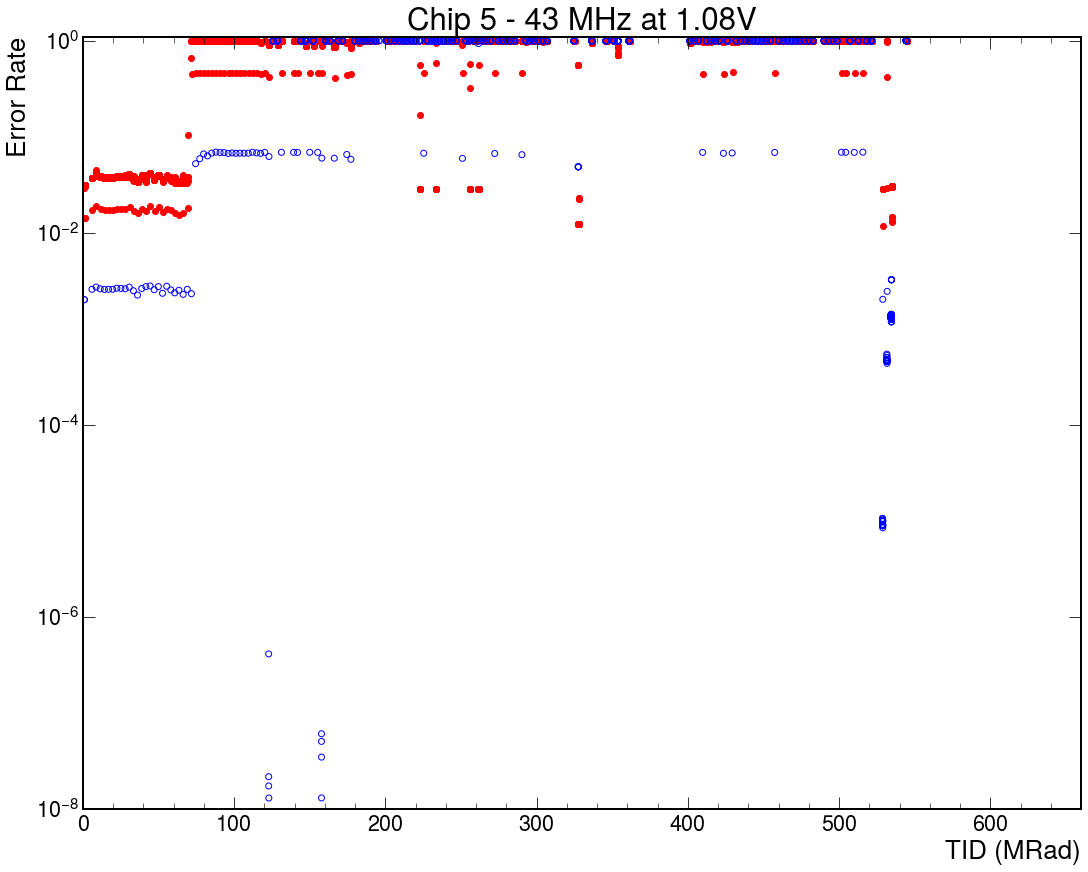

In [235]:
fig,axs=plt.subplots(figsize=(15,12), layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]

axs.scatter(megarad_dose_l1a[0], errs_rate_l1a[0], label = "errors w l1a", color = "r")
axs.scatter(megarad_dose_nol1a[0], errs_rate_nol1a[0], label = "errors w/o l1a",facecolors='none', edgecolors='b')
axs.set_ylabel("Error Rate")
axs.set_xlabel("TID (MRad)")
axs.set_title(f"Chip 5 - 43 MHz at 1.08V")
axs.set_yscale("log")
axs.set_ylim((1e-8,1.1))
axs.set_xlim(0,660)


fig.savefig(f'./word_err_err_rate_presentation_results_Chip5.jpg')

ValueError: x and y must be the same size

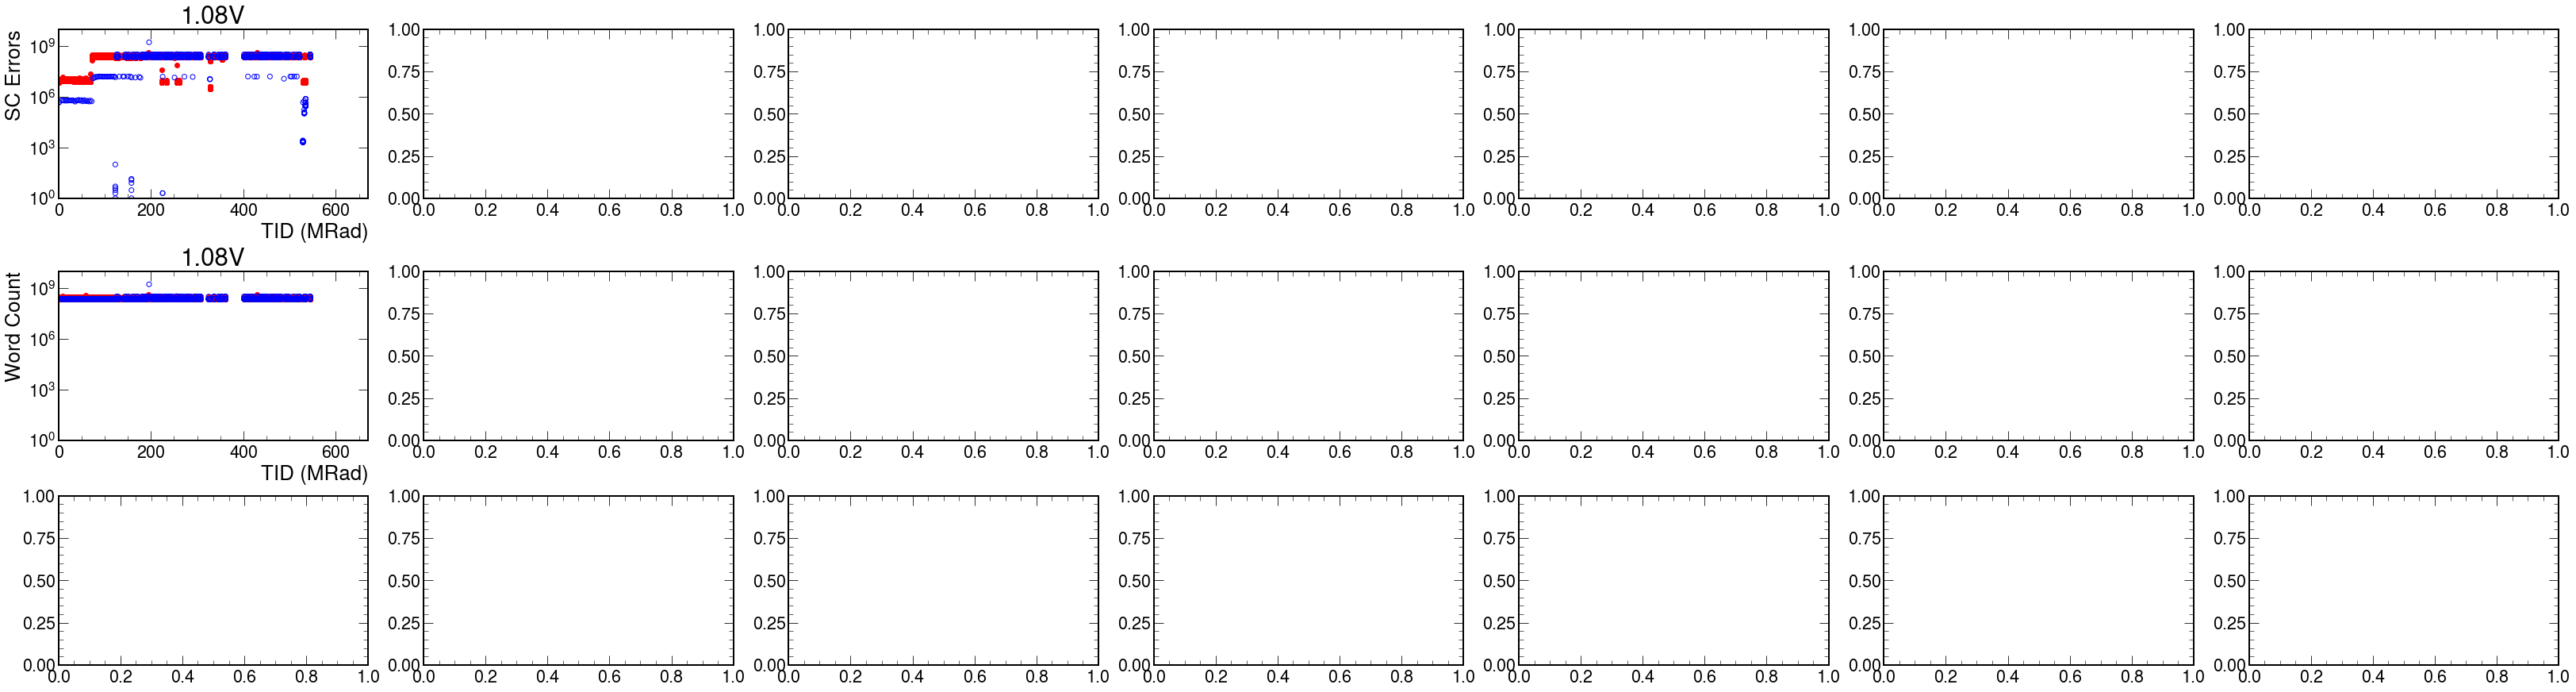

In [181]:
fig,axs=plt.subplots(figsize=(45,12),ncols=7,nrows=3, layout="constrained")
keylist = [1.08,1.11,1.14,1.20,1.26,1.29,1.32]
for j in range(len(keylist)):
    for i in range(3):
        if i == 0:
            axs[i,j].scatter(megarad_dose_l1a[j], errs_l1a[j], label = "errors w l1a", color = "r")
            axs[i,j].scatter(megarad_dose_nol1a[j], errs_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
            axs[i,j].set_ylabel("SC Errors")
            axs[i,j].set_xlabel("TID (MRad)")
            axs[i,j].set_title(f"{keylist[j]}V")
            axs[i,j].set_yscale("log")
            axs[i,j].set_ylim((1,1e10))
            axs[i,j].set_xlim(0,670)

            
      
            
        if i == 1:
            axs[i,j].scatter(megarad_dose_l1a[j], wordcnt_l1a[j], label = "errors w l1a", color = "r")
            axs[i,j].scatter(megarad_dose_nol1a[j],wordcnt_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
            axs[i,j].set_ylabel("Word Count")
            axs[i,j].set_xlabel("TID (MRad)")
            axs[i,j].set_title(f"{keylist[j]}V")
            axs[i,j].set_yscale("log")
            axs[i,j].set_ylim((1,1e10))
            axs[i,j].set_xlim(0,670)

            
        if i == 2:
            axs[i,j].scatter(megarad_dose_l1a[j], errs_rate_l1a[j], label = "errors w l1a", color = "r")
            axs[i,j].scatter(megarad_dose_nol1a[j], errs_rate_nol1a[j], label = "errors w/o l1a",facecolors='none', edgecolors='b')
            axs[i,j].set_ylabel("Error Rate")
            axs[i,j].set_xlabel("TID (MRad)")
            axs[i,j].set_title(f"{keylist[j]}V")
            axs[i,j].set_yscale("log")
            axs[i,j].set_ylim((1e-8,1.1))
            axs[i,j].set_xlim(0,670)

for ax in axs.flat:
    ax.label_outer()
fig.savefig('./word_err_err_rate_results.jpg')

In [ ]:
x1 = np.arange(0,len(errs_rate_1_2_l1a),1)
x2 = np.arange(0,len(errs_rate_1_2_nol1a),1)
plt.scatter(timestamps_1_2_l1a,errs_rate_1_2_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_2_nol1a,errs_rate_1_2_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.2V")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_08_l1a),1)
x2 = np.arange(0,len(errs_rate_1_08_nol1a),1)
plt.scatter(timestamps_1_08_l1a,errs_rate_1_08_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_08_nol1a,errs_rate_1_08_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.08V")
#plt.xlim(np.datetime64('2023-08-20T03:15:00'),np.datetime64('2023-08-20T03:20:00'))
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_08_l1a),1)
x2 = np.arange(0,len(errs_rate_1_08_nol1a),1)
plt.scatter(timestamps_1_08_l1a,errs_rate_1_08_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_08_nol1a,errs_rate_1_08_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.08V")
plt.xlim(np.datetime64('2023-08-19T13:05:50.392294'),np.datetime64('2023-08-19T13:05:55.776630'))
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_11_l1a),1)
x2 = np.arange(0,len(errs_rate_1_11_nol1a),1)
plt.scatter(timestamps_1_11_l1a,errs_rate_1_11_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_11_nol1a,errs_rate_1_11_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.11V")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_14_l1a),1)
x2 = np.arange(0,len(errs_rate_1_14_nol1a),1)
plt.scatter(timestamps_1_14_l1a,errs_rate_1_14_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_14_nol1a,errs_rate_1_14_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.14V")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_26_l1a),1)
x2 = np.arange(0,len(errs_rate_1_26_nol1a),1)
plt.scatter(timestamps_1_26_l1a,errs_rate_1_26_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_26_nol1a,errs_rate_1_26_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.26V")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_29_l1a),1)
x2 = np.arange(0,len(errs_rate_1_29_nol1a),1)
plt.scatter(timestamps_1_29_l1a,errs_rate_1_29_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_29_nol1a,errs_rate_1_29_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.29V")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
x1 = np.arange(0,len(errs_rate_1_32_l1a),1)
x2 = np.arange(0,len(errs_rate_1_32_nol1a),1)
plt.scatter(timestamps_1_32_l1a,errs_rate_1_32_l1a, label = "error rate w l1a", color = "r")
plt.scatter(timestamps_1_32_nol1a,errs_rate_1_32_nol1a, label = "error rate w/o l1a",color ="b")
plt.ylabel("error rate")
plt.xlabel("Measurement No.")
plt.title("1.32V")
plt.ylim(0,1)
plt.legend()
plt.show()